In [2]:
# this notebook is a 1D demo to show spectral bias in action
# just a function of time

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [4]:
import datetime
import os
import numpy as np
import math

import waveform
import sample
import model_utils
import dataset

In [5]:
import pandas as pd

In [6]:
import tensorflow as tf

In [7]:
import pycbc.pnutils

In [8]:
import lalsimulation as lalsim

In [9]:
plt.rcParams.update({'font.size':16})

# generate waveform data

In [10]:
def gen_waveform(mass_ratio=1, spin1x=0, spin1y=0, spin1z=0, spin2x=0, spin2y=0, spin2z=0, coa_phase=0, inclination=0, return_data='amp_phi'):
    nproc = 1
    
    # approximant="IMRPhenomXHM"
#     approximant="IMRPhenomXPHM"
    approximant="SEOBNRv4PHM"
    # approximant="IMRPhenomXAS"
#     approximant="IMRPhenomXP"
    # approximant="IMRPhenomD"
    # approximant="IMRPhenomHM"

    # uniform spacing throughout
    t1 = -10000
#     t1 = -4000
#     t1 = -2000
    # t1 = -500
    # t1 = -200
    # t1 = -50
    
#     t1 = -50
#     t2 = 70
    t2 = 100
    # t1 = -10
    # t2 = 20
    dt = 0.25
    new_times_M = np.arange(t1, t2, dt)

    t_idxs = np.arange(len(new_times_M))
    t_idxs_sample = t_idxs

    total_mass=100
    distance_mpc=1
    delta_t=1/4096
    f_lower=10
    
    starttime = datetime.datetime.now()

    times, thetas, hps, hcs = waveform.generate_waveforms_mp(
        new_times_M,
        [mass_ratio],
        [spin1x],
        [spin1y],
        [spin1z],
        [spin2x],
        [spin2y],
        [spin2z],
        [coa_phase],
        [inclination],
        time_idxs=t_idxs_sample,
        total_mass=total_mass,
        approximant=approximant,
        distance_mpc=distance_mpc,
        delta_t=delta_t,
        f_lower=f_lower,
        nproc=nproc,
        return_data=return_data,
    )

    endtime = datetime.datetime.now()
    duration = endtime - starttime
    print(f"The time cost: {duration}")
    

    # return times, thetas, hps, hcs
    # return times, thetas[:,0][:,np.newaxis], hps, hcs
    return times, thetas, hps, hcs
    # return times, thetas[:,7][:,np.newaxis], hps, hcs

In [11]:
# return_data='amp_phi'
return_data='hp_hc'

In [12]:
times, thetas, hps, hcs = gen_waveform(return_data=return_data, spin1x=0.8, mass_ratio=8, inclination=np.pi/2)

The time cost: 0:00:01.831929


In [13]:
train_thetas = thetas.copy()
val_thetas = thetas.copy()

In [14]:
train_times = times[::2].copy()
train_hps = hps[:,::2].copy()
train_hcs = hcs[:,::2].copy()

val_times = times[1::2].copy()
val_hps = hps[:,1::2].copy()
val_hcs = hcs[:,1::2].copy()

In [15]:
thetas.shape

(1, 9)

In [16]:
hps.shape

(1, 40400)

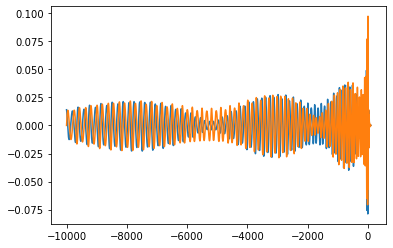

In [17]:
plt.plot(times, hps[0])
plt.plot(times, hcs[0])

(-100.0, 100.0)

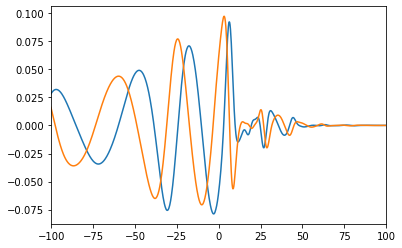

In [18]:
plt.plot(times, hps[0])
plt.plot(times, hcs[0])
plt.xlim(-100, 100)

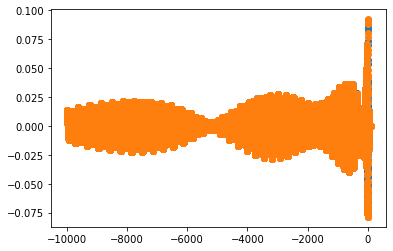

In [19]:
plt.plot(train_times, train_hps[0], 'o')
plt.plot(val_times, val_hps[0], 'o')

(-100.0, 100.0)

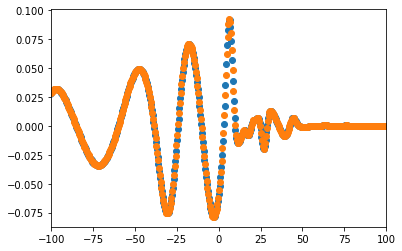

In [20]:
plt.plot(train_times, train_hps[0], 'o')
plt.plot(val_times, val_hps[0], 'o')
plt.xlim(-100, 100)

# fit model

In [21]:
# m1,m2 = pycbc.pnutils.mchirp_q_to_mass1_mass2(100, 8)
# m1,m2


m1,m2 = pycbc.pnutils.mtotal_eta_to_mass1_mass2(100, waveform.eta_from_q(8))
m1,m2

(88.88888888888889, 11.11111111111111)

time_b_scale: 0.03385
theta_b_scale: 1
theta_input_shape: 9
making traing dataset
making validation dataset
total_number_of_points (training): 20200
steps_per_epoch: 158
Metal device set to: Apple M1 Pro


2022-09-05 10:30:59.725646: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-05 10:30:59.725778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


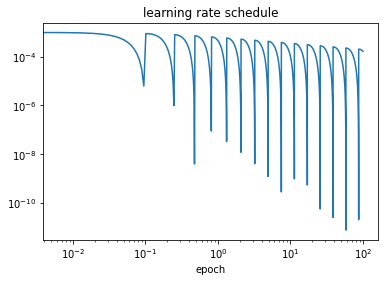

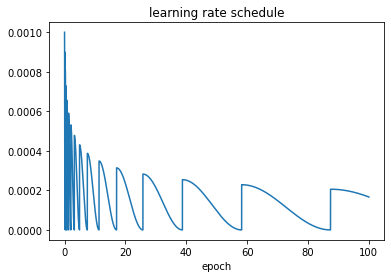

In [22]:
epochs = 100
#batch_size = 1024
# batch_size = 512
batch_size = 128
# batch_size = 64
# batch_size = 32

# f_rd_mf = waveform.HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=75, m2=25, s1z=0.99, s2z=0.99), 100)

# f_rd_mf = waveform.HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=m1, m2=m2, s1z=0.99, s2z=0.99), 100)

f_rd_mf = waveform.HztoMf(pycbc.pnutils._get_final_freq(approx=lalsim.SEOBNRv4, m1=m1, m2=m2, s1z=0., s2z=0.), 100)

time_b_scale = np.around(f_rd_mf, 4)/2
print(f"time_b_scale: {time_b_scale}")

theta_b_scale = 1
# theta_b_scale = 10
# theta_b_scale = 0.5
# theta_b_scale = 100
# theta_b_scale = 0.1
# theta_b_scale = 0.01
# theta_b_scale = 0.001
print(f"theta_b_scale: {theta_b_scale}")

theta_input_shape = train_thetas.shape[1]
print(f"theta_input_shape: {theta_input_shape}")

print("making traing dataset")
train_ds = dataset.DataGen(thetas=train_thetas, times=train_times, ys=train_hps, batch_size=batch_size, shuffle=True)

# del train_thetas, train_times, train_hps

print("making validation dataset")
val_ds = dataset.DataGen(thetas=val_thetas, times=val_times, ys=val_hps, batch_size=batch_size, shuffle=False) 

# del val_thetas, val_times, val_hps

total_number_of_points = train_ds.total_number_of_points
print(f"total_number_of_points (training): {total_number_of_points}")



# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
# steps_per_epoch = len(X_train) // batch_size
steps_per_epoch = math.ceil(total_number_of_points / batch_size)
# steps_per_epoch is the number of mini-batches per epoch
print(f"steps_per_epoch: {steps_per_epoch}")

n_cycles_per_epoch = 10
# n_cycles_per_epoch = 1

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
#     1e-4,
    1e-3,
    # 500*5,
    # 5,
    steps_per_epoch/n_cycles_per_epoch,
#     t_mul=2.0,
    t_mul=1.5,
#     t_mul=1.,
#     m_mul=1.,
    m_mul=0.9,
    alpha=0.0,
    name=None
)


step = np.arange(0, epochs * steps_per_epoch)
lr_ = lrs(step)

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
# plt.yscale('log')
# plt.xscale('log')
plt.show()
plt.close()



In [23]:
checkpoint_filepath = './checkpoint_dir_demo-1D/checkpoint'

In [24]:
# model_type='plain'
model_type='rff'

In [25]:
starttime = datetime.datetime.now()

history, model = model_utils.run_model_ds(
    train_ds=train_ds,
    time_b_scale=time_b_scale,
    theta_b_scale=theta_b_scale,
    theta_input_shape=theta_input_shape,
    epochs=epochs,
    threshold=1e-8,
    validation_data=val_ds,
    verbose=1,
    learning_rate=lrs,
#     learning_rate=1e-3,
    fan_in=128,
#     n_layers=20,
#     n_layers=9,
#     n_layers=6,
    n_layers=5,
#     units=1024,
    units=256,
#     units=32,
    activation='relu',
    # activation='softplus',
    # activation=tf.keras.layers.LeakyReLU(alpha=0.3),
    # activation='elu',
    # activation='selu',
    checkpoint_filepath=checkpoint_filepath,
    model_type=model_type
)

endtime = datetime.datetime.now()
duration = endtime - starttime
print(f"The time cost: {duration}")

Epoch 1/100


2022-09-05 10:31:00.302797: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/158 [..............................] - ETA: 1:17 - loss: 0.0072

2022-09-05 10:31:00.646534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/158 [============================>.] - ETA: 0s - loss: 0.0032

2022-09-05 10:31:02.312002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - 3s 14ms/step - loss: 0.0032 - val_loss: 8.3151e-05
Epoch 2/100
158/158 [==============================] - 2s 15ms/step - loss: 5.2288e-05 - val_loss: 2.8983e-05
Epoch 3/100
158/158 [==============================] - 3s 17ms/step - loss: 1.9088e-05 - val_loss: 1.1388e-05
Epoch 4/100
158/158 [==============================] - 2s 15ms/step - loss: 9.2963e-06 - val_loss: 5.5141e-06
Epoch 5/100
158/158 [==============================] - 2s 14ms/step - loss: 4.8588e-06 - val_loss: 4.2609e-06
Epoch 6/100
158/158 [==============================] - 2s 14ms/step - loss: 3.5921e-06 - val_loss: 2.2948e-06
Epoch 7/100
158/158 [==============================] - 2s 15ms/step - loss: 2.0913e-06 - val_loss: 1.7387e-06
Epoch 8/100
158/158 [==============================] - 2s 15ms/step - loss: 1.8054e-06 - val_loss: 1.7188e-06
Epoch 9/100
158/158 [==============================] - 2s 14ms/step - loss: 1.4686e-06 - val_loss: 1.0537e-06
Epoch 10/100
158/158 [====

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 9)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          256         ['time_input[0][0]']             
                                                                                                  
 dense_1 (Dense)                (None, 128)          1280        ['theta_input[0][0]']            
                                                                                              

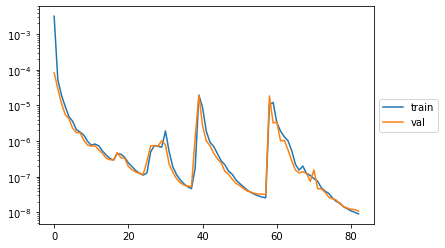

In [27]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# eval model

In [28]:
def build_input_single(t, *args):
    """
    t is a matrix i.e. shape = (-1, 1)
    list of parameters
    """
    theta = np.array([*args])
    theta = np.ones_like(t) * theta

    return np.column_stack((t, theta))

In [29]:
def build_input_multiple(t, thetas):
    """
    t is a vector
    thetas is a vector
    """
    return np.row_stack([build_input_single(t, *theta) for theta in thetas])

In [30]:
n_waveforms = val_thetas.shape[0]
n_times = val_times.shape[0]

In [31]:
Xval = build_input_multiple(val_times, val_thetas)

In [32]:
yhats_val = model([Xval[:,0], Xval[:,1:]])
yhats_val = yhats_val.numpy()
yhats_val = yhats_val.reshape(n_waveforms, n_times)

In [33]:
yhats_val.shape

(1, 20200)

In [34]:
mses = tf.keras.losses.mse(yhats_val, val_hps).numpy()

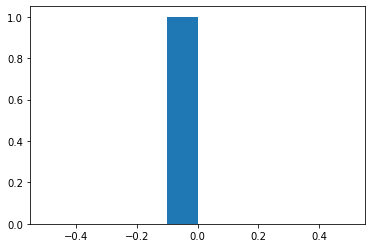

In [35]:
plt.hist(mses);

In [36]:
print(mses.min())
print(mses.max())
print(mses.mean())

1.0939370049089368e-08
1.0939370049089368e-08
1.0939370049089368e-08


In [37]:
worst_index = mses.argmax()

In [38]:
val_thetas[worst_index]

array([8.        , 0.8       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.57079633])

In [39]:
mses[worst_index]

1.0939370049089368e-08

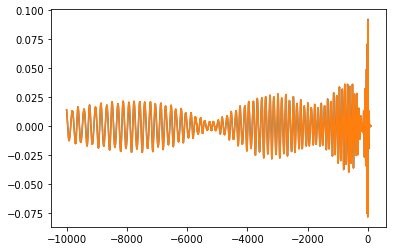

In [40]:
#worst
plt.figure()
plt.plot(val_times, val_hps[worst_index])
plt.plot(val_times, yhats_val[worst_index])
# plt.xlim(-100, 100)

(-100.0, 100.0)

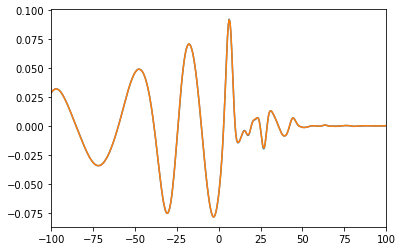

In [41]:
#worst
plt.figure()
plt.plot(val_times, val_hps[worst_index])
plt.plot(val_times, yhats_val[worst_index])
plt.xlim(-100, 100)

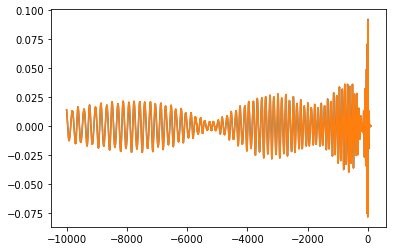

In [42]:
# best
plt.figure()
plt.plot(val_times, val_hps[mses.argmin()])
plt.plot(val_times, yhats_val[mses.argmin()])
# plt.xlim(-100, 100)

In [43]:
df_mse = pd.DataFrame({'mse':mses})

In [44]:
idxs = df_mse.index

In [45]:
df_mse.iloc[idxs]

mse
0  1.093937e-08

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


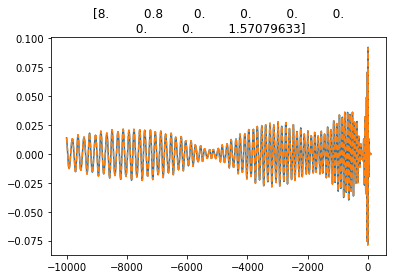

In [46]:
for i in idxs:
    plt.figure()
    plt.plot(val_times, val_hps[i])
    plt.plot(val_times, yhats_val[i], ls='--')
    plt.title(val_thetas[i])
    plt.show()
    plt.close()

# compute matches 

In [47]:
import waveform
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

In [48]:
val_hps[0].dtype 

dtype('float64')

In [49]:
yhats_val[0].dtype 

dtype('float32')

In [50]:
def compute_match(h1, h2, times, total_mass):

    f_low = 30

    dt = times[1] - times[0]
    dt = waveform.MtoS(dt, total_mass)
    h1 = TimeSeries(h1.astype("double"), delta_t=dt)
    h2 = TimeSeries(h2.astype("double"), delta_t=dt)
    
    # # Resize the waveforms to the same length
    tlen = max(len(h1), len(h2))
    h1.resize(tlen)
    h2.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / h1.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    # Note: This takes a while the first time as an FFT plan is generated
    # subsequent calls are much faster.
    m, _ = match(h1, h2, psd=psd, low_frequency_cutoff=f_low)
    
    return m

In [51]:
compute_match(val_hps[0], yhats_val[0], val_times[:,0], 100)

0.9998030628424269

In [52]:
 %%time
all_matches = []
for i in range(len(val_hps)):
    m = compute_match(val_hps[i], yhats_val[i], val_times[:,0], 100)
    all_matches.append(m)
all_matches = np.array(all_matches)

CPU times: user 9.8 ms, sys: 3.38 ms, total: 13.2 ms
Wall time: 5.01 ms


In [53]:
pd.DataFrame({'matches':all_matches}).describe() 

matches
count  1.000000
mean   0.999803
std         NaN
min    0.999803
25%    0.999803
50%    0.999803
75%    0.999803
max    0.999803

In [54]:
def plot_loghist(x, bins, axvlines=None):
    """
    https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.figure(figsize=(14, 6))
    plt.hist(x, bins=logbins, histtype='step', linewidth=4)
    plt.xscale('log')
    # plt.xlabel('mismatch')
    if axvlines is not None:
        for axvline in axvlines:
            plt.axvline(axvline, c='k')

/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_52191/2870374792.py:6: RuntimeWarning: invalid value encountered in log10
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))


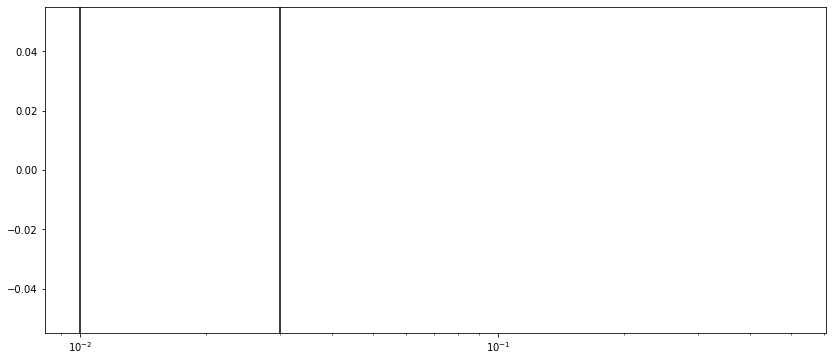

In [55]:
plot_loghist(1-all_matches, 20, axvlines=[1-0.97, 1-0.99]) 

In [56]:
df_matches = pd.DataFrame({'matches':all_matches}) 

In [57]:
df_matches = df_matches.sort_values(by='matches', ascending=True) 

In [58]:
df_matches.index 

Int64Index([0], dtype='int64')

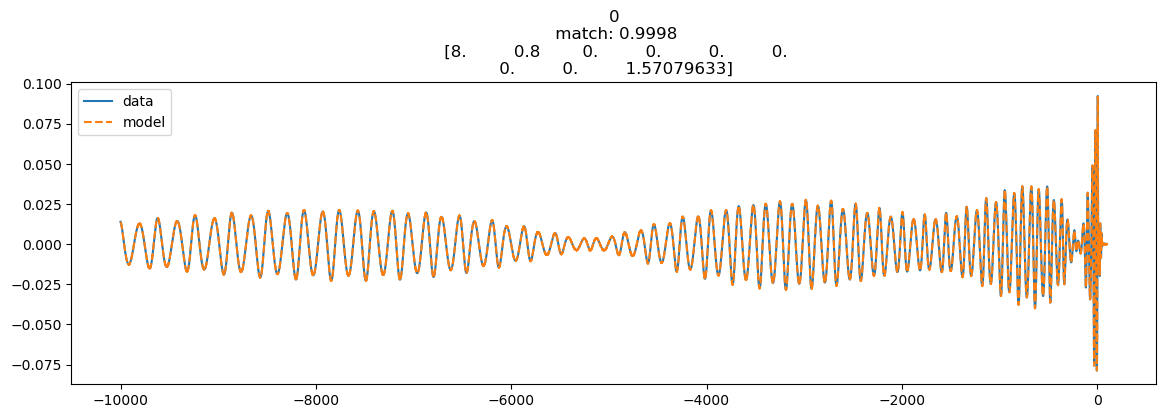

In [59]:
 for i in df_matches.index[:30]:
    plt.figure(figsize=(14, 4), dpi=100)
    plt.plot(val_times, val_hps[i], label='data')
    plt.plot(val_times, yhats_val[i], label='model', ls='--')
    # plt.xlim(-100, 100)
    plt.title(f"{i}\n match: {df_matches.loc[i].values[0]:.4f}\n {val_thetas[i]}")
    plt.legend()
    plt.show()
    plt.close()

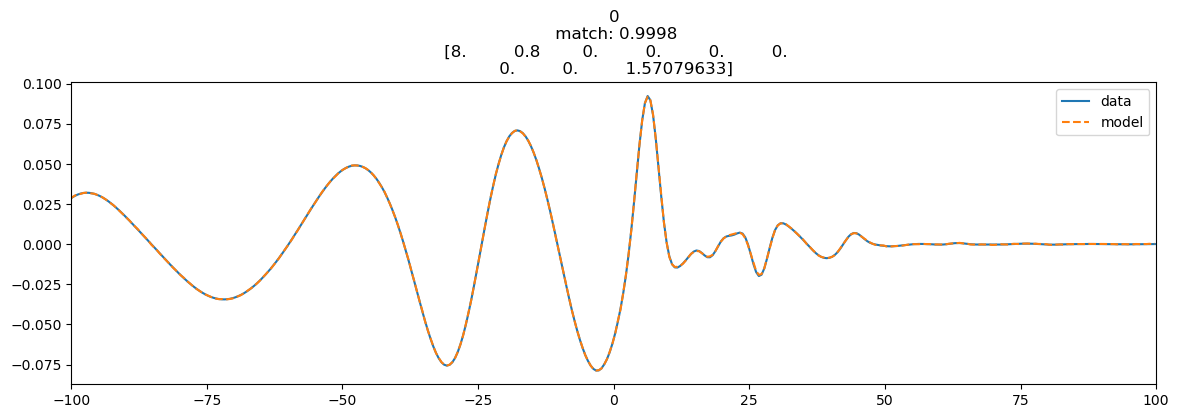

In [60]:
 for i in df_matches.index[:30]:
    plt.figure(figsize=(14, 4), dpi=100)
    plt.plot(val_times, val_hps[i], label='data')
    plt.plot(val_times, yhats_val[i], label='model', ls='--')
    plt.xlim(-100, 100)
    plt.title(f"{i}\n match: {df_matches.loc[i].values[0]:.4f}\n {val_thetas[i]}")
    plt.legend()
    plt.show()
    plt.close()

# plain model

In [61]:
starttime = datetime.datetime.now()

history_plain, model_plain = model_utils.run_model_ds(
    train_ds=train_ds,
    time_b_scale=time_b_scale,
    theta_b_scale=theta_b_scale,
    theta_input_shape=theta_input_shape,
    epochs=epochs,
    threshold=1e-7,
    validation_data=val_ds,
    verbose=1,
    learning_rate=lrs,
#     learning_rate=1e-3,
    fan_in=128,
#     n_layers=20,
#     n_layers=9,
#     n_layers=6,
    n_layers=3,
#     units=1024,
    units=256,
#     units=32,
    activation='relu',
    # activation='softplus',
    # activation=tf.keras.layers.LeakyReLU(alpha=0.3),
    # activation='elu',
    # activation='selu',
    checkpoint_filepath=checkpoint_filepath,
    model_type='plain'
)

endtime = datetime.datetime.now()
duration = endtime - starttime
print(f"The time cost: {duration}")

Epoch 1/100


2022-09-05 10:33:51.961772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - ETA: 0s - loss: 4057.9595

2022-09-05 10:33:53.628181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - 3s 14ms/step - loss: 4057.9595 - val_loss: 0.0147
Epoch 2/100
158/158 [==============================] - 2s 12ms/step - loss: 0.0106 - val_loss: 0.0079
Epoch 3/100
158/158 [==============================] - 2s 11ms/step - loss: 0.0625 - val_loss: 0.0100
Epoch 4/100
158/158 [==============================] - 2s 11ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 5/100
158/158 [==============================] - 2s 13ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 6/100
158/158 [==============================] - 2s 14ms/step - loss: 0.0237 - val_loss: 0.0292
Epoch 7/100
158/158 [==============================] - 2s 13ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 8/100
158/158 [==============================] - 2s 11ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 9/100
158/158 [==============================] - 2s 13ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 10/100
158/158 [==============================] - 2s 13ms/step - loss: 0.0026 - val_l

In [62]:
model_plain.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 9)]          0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 128)          256         ['time_input[0][0]']             
                                                                                                  
 dense_9 (Dense)                (None, 128)          1280        ['theta_input[0][0]']            
                                                                                            

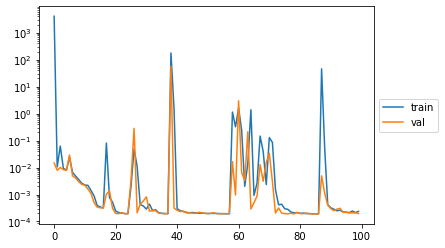

In [63]:
plt.figure()
plt.plot(history_plain.history['loss'], label='train')
plt.plot(history_plain.history['val_loss'], label='val')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [64]:
yhats_val_plain = model_plain([Xval[:,0], Xval[:,1:]])
yhats_val_plain = yhats_val_plain.numpy()
yhats_val_plain = yhats_val_plain.reshape(n_waveforms, n_times)

Text(0.5, 0.0, 't/M')

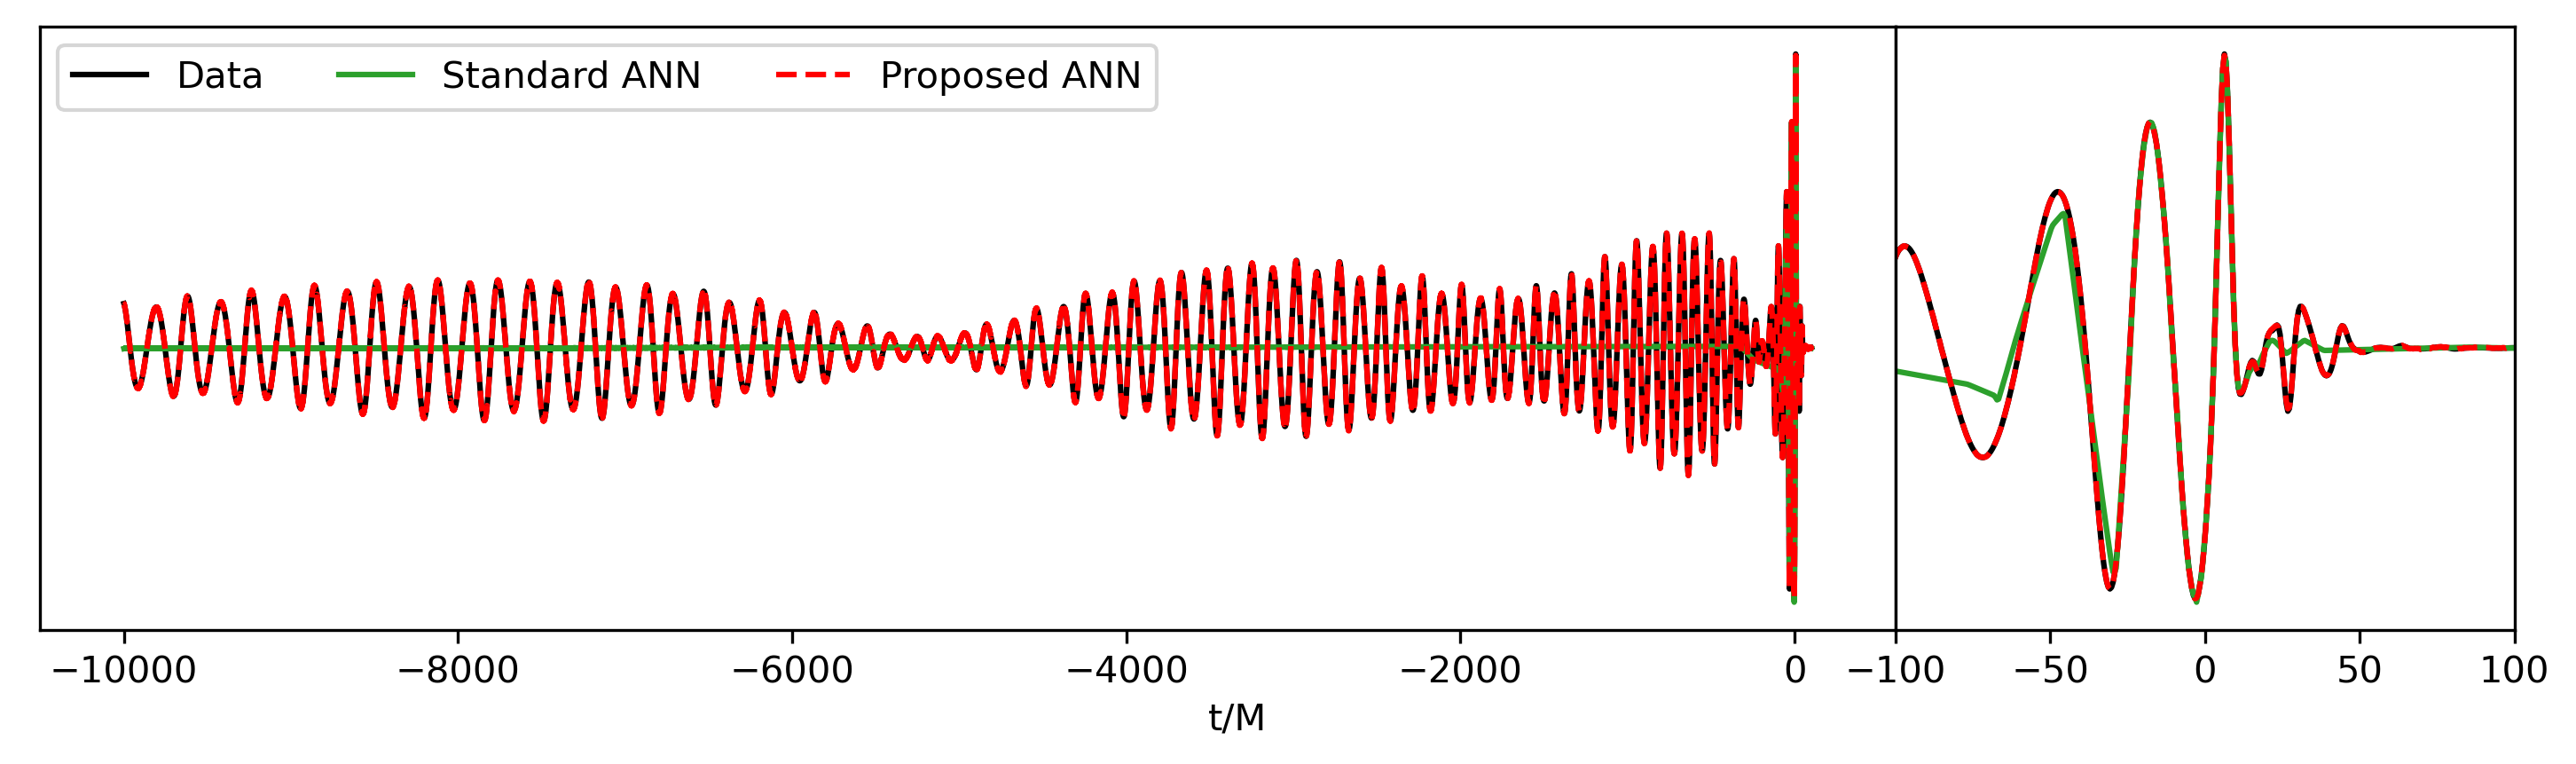

In [65]:
fig = plt.figure(figsize=(12, 3), dpi=300)
grid = plt.GridSpec(1, 4, wspace=0., hspace=0.3, figure=fig)
plt.subplot(grid[0, :3])
plt.plot(val_times, val_hps[0], label='Data', c='k')
plt.plot(val_times, yhats_val_plain[0], label='Standard ANN', ls='-', c='C2')
plt.plot(val_times, yhats_val[0], label='Proposed ANN', ls='--', c='r')
plt.legend(ncol=3)
plt.yticks([])

plt.subplot(grid[0, 3]);
plt.plot(val_times, val_hps[0], label='data', c='k')
plt.plot(val_times, yhats_val_plain[0], label='Standard ANN', ls='-', c='C2')
plt.plot(val_times, yhats_val[0], label='Proposed ANN', ls='--', c='r')
plt.xlim(-100, 100)
plt.yticks([])

fig.text(0.5, 0.0, 't/M', ha='center')



In [66]:
out = np.column_stack((val_times, yhats_val_plain[0]))

In [68]:
out.shape

(20200, 2)

In [67]:
# np.save("plain.npy", out)

In [69]:
# !cp plain.npy ~/Desktop